# Recurrent Neural Networks Demo

Author: Runshan Fu (Fall 2017 95-865 TA), George H. Chen

In this demo, we will implement RNN models for sentiment analysis on IMDB reviews. We will start from the original review texts and predict the sentiment (positive or negative) for each review. This demo is borrowed from the book *Deep Learning with Python* by Francois Chollet and also uses code from user `mdaoust` in [this stackoverflow post](https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Load the dataset
We directly load the data as lists of intergers from keras. We restrict the movie reviews to the top 2000 most common words, and make all the reviews exactly 200 words (truncating as needed or padding with a special padding character; note that truncating works by removing the *start* of the review and keeping only the last 200 words; padding works by adding the special padding character to the *start* of the review).

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# load the dataset and only keep the top words (most frequently occurring)
vocab_size = 2000
INDEX_FROM = 2  # for dealing with some special characters; this is a technical thing related to the IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size, index_from=INDEX_FROM)

word_to_idx = imdb.get_word_index()
word_to_idx = {word:(word_idx + INDEX_FROM) for word, word_idx in word_to_idx.items()}
word_to_idx['<PAD>'] = 0
word_to_idx['<START>'] = 1
word_to_idx['<UNK>'] = 2

idx_to_word = {word_idx:word for word, word_idx in word_to_idx.items()}

# turn the lists of integers into a 2D integer tensor of shape `(samples, maxlen)`
x_train = sequence.pad_sequences(x_train, maxlen=200)
x_test = sequence.pad_sequences(x_test, maxlen=200)

Using TensorFlow backend.


In [3]:
print(x_train.shape)

(25000, 200)


In [4]:
print(x_train[0])

[   4   24   99   42  837  111   49  669    2    8   34  479  283    4
  149    3  171  111  166    2  335  384   38    3  171    2 1110   16
  545   37   12  446    3  191   49   15    5  146    2   18   13   21
    3 1919    2  468    3   21   70   86   11   15   42  529   37   75
   14   12 1246    3   21   16  514   16   11   15  625   17    2    4
   61  385   11    7  315    7  105    4    3    2    2   15  479   65
    2   32    3  129   11   15   37  618    4   24  123   50   35  134
   47   24 1414   32    5   21   11  214   27   76   51    4   13  406
   15   81    2    7    3  106  116    2   14  255    3    2    6    2
    4  722   35   70   42  529  475   25  399  316   45    6    3    2
 1028   12  103   87    3  380   14  296   97   31    2   55   25  140
    5  193    2   17    3  225   21   20  133  475   25  479    4  143
   29    2   17   50   35   27  223   91   24  103    3  225   64   15
   37 1333   87   11   15  282    4   15    2  112  102   31   14   15
    2 

Here is an example of a review with positive sentiment (this particular review has been truncated, so we only see the last 200 words of the review):

In [5]:
print(' '.join(idx_to_word[idx] for idx in x_train[0]))

and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same <UNK> island as myself so i loved the fact there was a real <UNK> with this film the witty <UNK> throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the <UNK> <UNK> was amazing really <UNK> at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of <UNK> and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all <UNK> up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they have done don't you think the whole story was so lovely because it was true and was <UNK> life after all that was <UNK> with us all


In [6]:
y_train[0]

1

Here is an example of a review with negative sentiment (this particular review has been padded at the beginning; note that when we can see the starting of a review, the first token of the actual review is a special token `<START>`):

In [7]:
print(' '.join(idx_to_word[idx] for idx in x_train[-3]))

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> in a far away <UNK> is a planet called <UNK> it's <UNK> people <UNK> <UNK> but the dog people <UNK> war upon these <UNK> loving people and they have no choice but to go to earth and <UNK> people up for food this is one of the <UNK> f <UNK> <UNK> ideas for a movie i've seen leave it to <UNK> <UNK> to make a movie more <UNK> than the already low standard he set in previous films it's like he <UNK> playing in a <UNK> game of <UNK> how low can he go the only <UNK> in the <UNK> are us the viewer mr <UNK> and his silly little <UNK> <UNK> actually has people who still buy this crap br br my grade f br br dvd <UNK> commentary by <UNK> <UNK> the story behind the making of 9 and a half minutes <UNK> minutes 15 seconds of behind the scenes footage <UNK> <UNK> <UNK> and <UNK> for the <UNK> <UNK> girl in gold <UNK> the <UNK> <UNK> ten violent women featuring nudity blood <UNK> of the she <UNK> th

In [8]:
y_train[-3]

0

## Use pre-trained word embeddings
We use GloVe embeddings instead of learning our own task-specific word embedding. First download the pre-computed embeddings from 2014 English Wikipedia on https://nlp.stanford.edu/projects/glove/ (specifically the one with 6 billion tokens, `globe.6B.zip`). Unzip it (so that `glove.6B.100d.txt` is located in the directory `./glove/`).

We first create a dictionary that maps each English word to its corresponding 100-dimensional GloVe embedding.

In [9]:
word_to_embedding = {}

# we will use the 100-dimensional embedding vectors
with open("./glove/glove.6B.100d.txt") as f:
    # each row represents a word vector
    for line in f:
        values = line.split()
        # the first part is word
        word = values[0]
        # the rest of the values form the embedding vector
        embedding = np.asarray(values[1:], dtype='float32')
        word_to_embedding[word] = embedding

print('Found %s word vectors.' % len(word_to_embedding))

Found 400000 word vectors.


Next, we create an embedding matrix, where the i-th row holds the GloVe embedding for the i-th top word (except where i=0 is the special padding token `<PAD>`, i=1 is the special `<START>` token, and i=2 is the special `<UNK>` token; for these special cases the embedding vector is left as all zeros).

In [10]:
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for idx in range(vocab_size):
    word = idx_to_word[idx]
    if word in word_to_embedding:
        embedding_matrix[idx] = word_to_embedding[word]

## Feedforward network with embeddings

This first neural net is *not* a recurrent neural net. It does not do anything special to account for time series structure. This net is meant to be a baseline that we compare a recurrent neural net against. To make the comparison somewhat fair, in both cases, the last two layers have the same output dimensions: the second-to-last layer is a Dense layer with 64 neurons and `relu` activation, and the last layer is a Dense layer with 1 neuron and `sigmoid` activation.

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
# initialize the model
feedforward_model = Sequential()
feedforward_model.add(Embedding(vocab_size, embedding_dim, input_length=200))
feedforward_model.add(Flatten())
feedforward_model.add(Dense(64, activation='relu'))
feedforward_model.add(Dense(1, activation='sigmoid'))
feedforward_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          200000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1280064   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,480,129
Trainable params: 1,480,129
Non-trainable params: 0
_________________________________________________________________


In [12]:
# load the GloVe embeddings in the model
feedforward_model.layers[0].set_weights([embedding_matrix])
# set the embedding layer to be not trainable, so the weights do not change during the training
feedforward_model.layers[0].trainable = False

feedforward_model.summary()  # the summary changes after we turn off training for the 0-th layer (note the last line "Non-trainable params")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          200000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1280064   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,480,129
Trainable params: 1,280,129
Non-trainable params: 200,000
_________________________________________________________________


In [13]:
# compile and train the model
feedforward_model.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['acc'])

history = feedforward_model.fit(x_train, y_train,
                                validation_split=0.2,
                                epochs=10,
                                batch_size=32)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 14s 686us/step - loss: 0.6309 - acc: 0.6500 - val_loss: 0.5866 - val_acc: 0.6856
Epoch 2/10
20000/20000 [==============================] - 13s 651us/step - loss: 0.4821 - acc: 0.7722 - val_loss: 0.5610 - val_acc: 0.7232
Epoch 3/10
20000/20000 [==============================] - 13s 660us/step - loss: 0.4004 - acc: 0.8179 - val_loss: 0.5807 - val_acc: 0.7176
Epoch 4/10
20000/20000 [==============================] - 13s 673us/step - loss: 0.3227 - acc: 0.8597 - val_loss: 0.6451 - val_acc: 0.7126
Epoch 5/10
20000/20000 [==============================] - 13s 653us/step - loss: 0.2503 - acc: 0.8947 - val_loss: 0.7348 - val_acc: 0.7100
Epoch 6/10
20000/20000 [==============================] - 13s 629us/step - loss: 0.1787 - acc: 0.9286 - val_loss: 0.8210 - val_acc: 0.7106
Epoch 7/10
20000/20000 [==============================] - 14s 686us/step - loss: 0.1028 - acc: 0.9650 - val_loss: 0.9

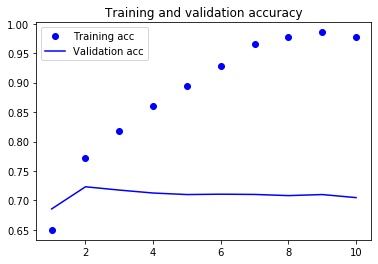

In [14]:
# plot the accuracy rates for each epoch on training and validation data
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

## LSTM

Now we use an LSTM recurrent neural net. If you want to use a different kind of RNN such as `SimpleRNN` or `GRU`, simply replace `LSTM` with `SimpleRNN` or `GRU` (both in importing the layer and in adding the layer to the model).

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, embedding_dim, input_length=200))
rnn_model.add(LSTM(64))
rnn_model.add(Dense(1, activation='sigmoid'))

# load the GloVe embeddings in the model
rnn_model.layers[0].set_weights([embedding_matrix])
rnn_model.layers[0].trainable = False

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          200000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 242,305
Trainable params: 42,305
Non-trainable params: 200,000
_________________________________________________________________


In [16]:
# compile and train the model
rnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])
history = rnn_model.fit(x_train, y_train,
                        validation_split=0.2,
                        epochs=10,
                        batch_size=32)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.5707 - acc: 0.7016 - val_loss: 0.5012 - val_acc: 0.7534
Epoch 2/10
20000/20000 [==============================] - 85s 4ms/step - loss: 0.4279 - acc: 0.8048 - val_loss: 0.4189 - val_acc: 0.8126
Epoch 3/10
20000/20000 [==============================] - 83s 4ms/step - loss: 0.3690 - acc: 0.8366 - val_loss: 0.3670 - val_acc: 0.8394
Epoch 4/10
20000/20000 [==============================] - 85s 4ms/step - loss: 0.3420 - acc: 0.8520 - val_loss: 0.3361 - val_acc: 0.8522
Epoch 5/10
20000/20000 [==============================] - 87s 4ms/step - loss: 0.3173 - acc: 0.8627 - val_loss: 0.3382 - val_acc: 0.8510
Epoch 6/10
20000/20000 [==============================] - 83s 4ms/step - loss: 0.2980 - acc: 0.8733 - val_loss: 0.3764 - val_acc: 0.8352
Epoch 7/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.2806 - acc: 0.8801 - val_loss: 0.3622 - val_acc:

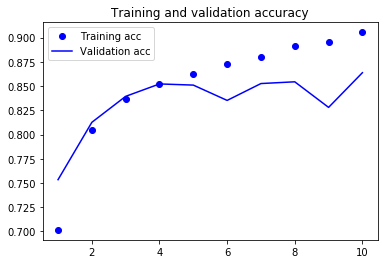

In [17]:
# plot the accuracy rates for each epoch on training and validation data
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

## Finally evaluate on test data

We now compare the test set raw classification accuracies of the feedforward neural net vs the LSTM model. Keep in mind that we have set both of these models up so that right before the final logistic regression classification layer, we are representing each review as a feature vector of length 64. The LSTM model learns a much better 64-dimensional feature space to use (as evidenced by its dramatically higher prediction accuracy on the test set).

In [18]:
test_loss, test_acc = feedforward_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

25000/25000 [==============================] - 2s 85us/step
Test accuracy: 0.700439989566803


In [19]:
test_loss, test_acc = rnn_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

25000/25000 [==============================] - 22s 868us/step
Test accuracy: 0.8664799928665161


To get predictions, we use the `predict_classes` function (note that there is a `predict` function that outputs whatever is the neural net's final output, which in this case is the probability of positive sentiment per test example, since the final layer is a Dense layer with 1 neuron and sigmoid activation).

In [23]:
predicted_labels = rnn_model.predict_classes(x_test)

In [24]:
predicted_labels

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]], dtype=int32)

In [25]:
np.mean(predicted_labels.flatten() == y_test)

0.86648

In case you're wondering how the predicted labels are computed, we can simply look at the raw neural net outputs (which are probabilities) and threshold at probability 0.5 (i.e., declare every test example with probability at least 0.5 of having positive sentiment to be in the positive sentiment class and declare all other test examples to have negative sentiment).

In [20]:
test_set_predicted_probs = rnn_model.predict(x_test)

In [21]:
test_set_predicted_probs

array([[0.00192991],
       [0.9505013 ],
       [0.7850129 ],
       ...,
       [0.00563908],
       [0.06085095],
       [0.7172326 ]], dtype=float32)

The code below computes the test set accuracy of `rnn_model`. Note that `test_set_predicted_probs >= .5` converts the test set predicted probabilities into actual classifications (1 if the predicted probability is greater than .5 and 0 otherwise). Flattening is needed since `test_set_predicted_probs >= .5` is actually a 2D array.

In [22]:
np.mean((test_set_predicted_probs >= .5).flatten() == y_test)

0.86648